In [ ]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

# **Loading Dataset**

In [ ]:
df = pd.read_csv('zomato.csv', encoding='latin-1')

In [ ]:
df.columns

Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Rating text',
       'Votes'],
      dtype='object')

In [ ]:
df.describe()

,Restaurant ID,Country Code,Longitude,Latitude,Average Cost for two,Price range,Aggregate rating,Votes
count,9.551000e+03,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000,9551.000000
mean,9.051128e+06,18.365616,64.126574,25.854381,1199.210763,1.804837,2.666370,156.909748
std,8.791521e+06,56.750546,41.467058,11.007935,16121.183073,0.905609,1.516378,430.169145
min,5.300000e+01,1.000000,-157.948486,-41.330428,0.000000,1.000000,0.000000,0.000000
25%,3.019625e+05,1.000000,77.081343,28.478713,250.000000,1.000000,2.500000,5.000000
50%,6.004089e+06,1.000000,77.191964,28.570469,400.000000,2.000000,3.200000,31.000000
75%,1.835229e+07,1.000000,77.282006,28.642758,700.000000,2.000000,3.700000,131.000000
max,1.850065e+07,216.000000,174.832089,55.976980,800000.000000,4.000000,4.900000,10934.000000


# **Transforming DataFrame**

##**Selecting Columns**

In [ ]:
# Select specific columns to create a new DataFrame
selected_columns = ['Restaurant ID', 'Restaurant Name', 'City', 'Address', 'Longitude', 'Latitude', 'Cuisines', 'Aggregate rating', 'Votes']
newDf = df[selected_columns]

# Rename columns in the new DataFrame
newDf = newDf.rename(columns={'Aggregate rating': 'Rating', 'Votes': 'Reviews'})

###**Checking Duplicates**

In [ ]:
# Check duplicates
check_columns = ['Restaurant Name', 'City', 'Address', 'Longitude', 'Latitude']
duplicated_rows = newDf[newDf.duplicated(subset=check_columns, keep=False)]

# Duplicated rows
duplicated_rows.shape

(0, 9)

In [ ]:
newDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Restaurant ID    9551 non-null   int64  
 1   Restaurant Name  9551 non-null   object 
 2   City             9551 non-null   object 
 3   Address          9551 non-null   object 
 4   Longitude        9551 non-null   float64
 5   Latitude         9551 non-null   float64
 6   Cuisines         9542 non-null   object 
 7   Rating           9551 non-null   float64
 8   Reviews          9551 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 671.7+ KB


##**Converting Objects to Category**

In [ ]:
for column, row in newDf.items():
    if not pd.api.types.is_numeric_dtype(row):
        newDf[column] = row.astype("category").cat.as_ordered()

In [ ]:
newDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Restaurant ID    9551 non-null   int64   
 1   Restaurant Name  9551 non-null   category
 2   City             9551 non-null   category
 3   Address          9551 non-null   category
 4   Longitude        9551 non-null   float64 
 5   Latitude         9551 non-null   float64 
 6   Cuisines         9542 non-null   category
 7   Rating           9551 non-null   float64 
 8   Reviews          9551 non-null   int64   
dtypes: category(4), float64(3), int64(2)
memory usage: 1.1 MB


##**Using One Hot Encoder**

In [ ]:
# categories = ["Restaurant Name", "City", "Address", "Cuisines"]
# prefixes = ["restaurant-name", "city", "address", "cuisine"]

# for i, prefix in zip(categories, prefixes):
#     one_hot = pd.get_dummies(newDf[i], prefix=prefix)

#     # Concatenate the original DataFrame and the one-hot encoded DataFrame along the column axis
#     newDf = pd.concat([df, one_hot], axis=1)
#     newDf = newDf.drop(i, axis=1)

# # Resulting DataFrame
# newDf

In [ ]:
newDf.head()

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
0,6317637,Le Petit Souffle,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...",121.027535,14.565443,"French, Japanese, Desserts",4.8,314
1,6304287,Izakaya Kikufuji,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...",121.014101,14.553708,Japanese,4.5,591
2,6300002,Heat - Edsa Shangri-La,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4.4,270
3,6318506,Ooma,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...",121.056475,14.585318,"Japanese, Sushi",4.9,365
4,6314302,Sambo Kojin,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...",121.057508,14.584450,"Japanese, Korean",4.8,229


In [ ]:
newDf.isna()

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
9546,False,False,False,False,False,False,False,False,False
9547,False,False,False,False,False,False,False,False,False
9548,False,False,False,False,False,False,False,False,False
9549,False,False,False,False,False,False,False,False,False


##**Checking null values**

In [ ]:
newDf.loc[newDf.isnull().any(axis=1)]

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
84,17284105,Cookie Shoppe,Albany,"115 N Jackson St, Albany, GA 31701",-84.154000,31.577200,NaN,3.4,34
87,17284211,Pearly's Famous Country Cookng,Albany,"814 N Slappey Blvd, Albany, GA 31701",-84.175900,31.588200,NaN,3.4,36
94,17284158,Jimmie's Hot Dogs,Albany,"204 S Jackson St, Albany, GA 31701",-84.153400,31.575100,NaN,3.9,160
297,17374552,Corkscrew Cafe,Gainesville,"51 W Main St, Dahlonega, GA 30533",-83.985800,34.531800,NaN,3.9,209
328,17501439,Dovetail,Macon,"543 Cherry St, Macon, GA 31201",-83.627979,32.836410,NaN,3.8,102
346,17606621,HI Lite Bar & Lounge,Miller,"109 N Broadway Ave, Miller, SD 57362",-98.989100,44.515800,NaN,3.4,11
368,17059060,Hillstone,Orlando,"215 South Orlando Avenue, Winter Park, FL 32789",-81.365260,28.596682,NaN,4.4,1158
418,17142698,Leonard's Bakery,Rest of Hawaii,"933 Kapahulu Ave, Honolulu, HI 96816",-157.813432,21.284586,NaN,4.7,707
455,17616465,Tybee Island Social Club,Savannah,"1311 Butler Ave, Tybee Island, GA 31328",-80.848297,31.995810,NaN,3.9,309


In [ ]:
newDf.isnull().sum()

Restaurant ID      0
Restaurant Name    0
City               0
Address            0
Longitude          0
Latitude           0
Cuisines           9
Rating             0
Reviews            0
dtype: int64

###**Removing null values**

In [ ]:
newDf = newDf.dropna(axis=0)
newDf.shape

(9542, 9)


# **Analysing DataFrame**


##**Analzying Rating**

<Axes: xlabel='Rating'>

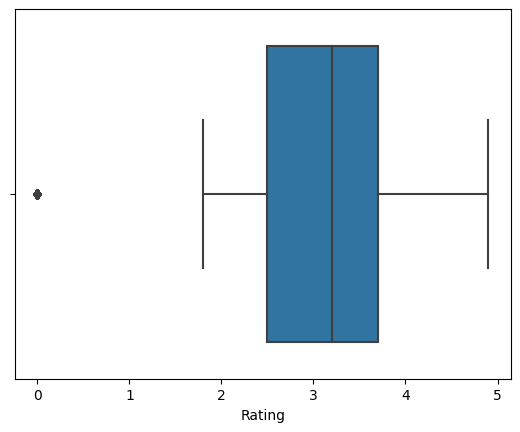

In [ ]:
sns.boxplot(data=newDf, x="Rating")

In [ ]:
threshold_rating = 1

# Keep only the rows where 'Rating' is greater than or equal to the threshold
newDf = newDf[newDf['Rating'] >= threshold_rating]

# Sort the resulting DataFrame in ascending order based on the 'Rating' column
newDf = newDf.sort_values(by='Rating', ascending=True)

# Display the updated DataFrame
newDf

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
1138,1683,Pind Balluchi,Ghaziabad,"Shop 34-40, Level 3, Shipra Mall, Gulmohar Roa...",77.370165,28.633970,"North Indian, Mughlai",1.8,322
4224,7018,Muffins,New Delhi,"B-3/66, Janakpuri, New Delhi",77.091798,28.627836,"Bakery, Fast Food",1.9,66
7507,149,Subway,New Delhi,"54, The India Mall, Community Centre, New Frie...",77.268517,28.561470,"American, Fast Food, Salad, Healthy Food",1.9,146
5197,7661,New Baba Da Dhaba,New Delhi,"J1/110, Gupta Colony, Near Saini Estate, Khirk...",77.217028,28.533122,"North Indian, Mughlai, Chinese",2.0,84
9106,2025,Moti Mahal Delux Tandoori Trail,Noida,"Food Court, The Great India Place Mall, Sector...",77.325445,28.567040,"North Indian, Mughlai",2.0,108
...,...,...,...,...,...,...,...,...,...
507,17095098,Mazzaro's Italian Market,Tampa Bay,"2909 22nd Ave N, St Petersburg, FL 33713",-82.673621,27.792047,"Italian, Deli",4.9,1424
2418,800468,Grandson of Tunday Kababi,Lucknow,"Naaz Cinema Road, Aminabad, Lucknow",80.927431,26.848506,"Mughlai, Lucknowi",4.9,1057
509,17095236,Mr. Dunderbak's Biergarten and Marketplatz,Tampa Bay,"14929 Bruce B Downs Blvd, Tampa, FL 33612",-82.412940,28.082909,"European, German",4.9,1413
8,6300010,Spiral - Sofitel Philippine Plaza Manila,Pasay City,"Plaza Level, Sofitel Philippine Plaza Manila, ...",120.980090,14.552990,"European, Asian, Indian",4.9,621


<Axes: xlabel='Rating'>

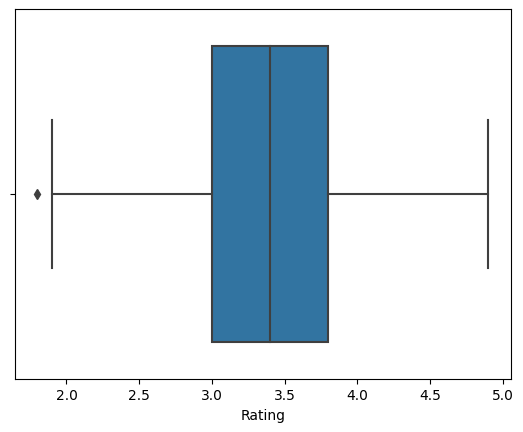

In [ ]:
sns.boxplot(data=newDf, x="Rating")


##**Analzying Reviews**

<Axes: xlabel='Reviews'>

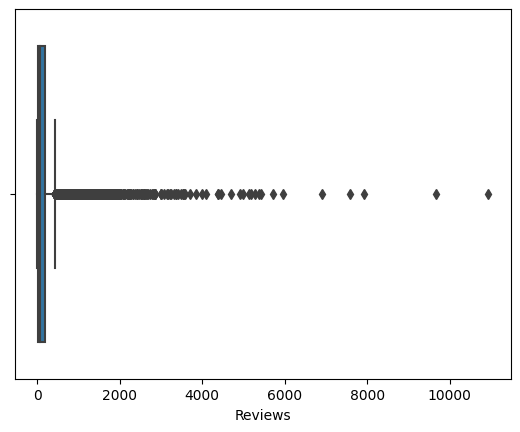

In [ ]:
sns.boxplot(data=newDf, x="Reviews")

In [ ]:
threshold_reviews = 10

# Keep only the rows where 'Rating' is greater than or equal to the threshold
newDf = newDf[newDf['Reviews'] >= threshold_reviews]

# Display the updated DataFrame
newDf

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
1138,1683,Pind Balluchi,Ghaziabad,"Shop 34-40, Level 3, Shipra Mall, Gulmohar Roa...",77.370165,28.633970,"North Indian, Mughlai",1.8,322
4224,7018,Muffins,New Delhi,"B-3/66, Janakpuri, New Delhi",77.091798,28.627836,"Bakery, Fast Food",1.9,66
7507,149,Subway,New Delhi,"54, The India Mall, Community Centre, New Frie...",77.268517,28.561470,"American, Fast Food, Salad, Healthy Food",1.9,146
5197,7661,New Baba Da Dhaba,New Delhi,"J1/110, Gupta Colony, Near Saini Estate, Khirk...",77.217028,28.533122,"North Indian, Mughlai, Chinese",2.0,84
9106,2025,Moti Mahal Delux Tandoori Trail,Noida,"Food Court, The Great India Place Mall, Sector...",77.325445,28.567040,"North Indian, Mughlai",2.0,108
...,...,...,...,...,...,...,...,...,...
507,17095098,Mazzaro's Italian Market,Tampa Bay,"2909 22nd Ave N, St Petersburg, FL 33713",-82.673621,27.792047,"Italian, Deli",4.9,1424
2418,800468,Grandson of Tunday Kababi,Lucknow,"Naaz Cinema Road, Aminabad, Lucknow",80.927431,26.848506,"Mughlai, Lucknowi",4.9,1057
509,17095236,Mr. Dunderbak's Biergarten and Marketplatz,Tampa Bay,"14929 Bruce B Downs Blvd, Tampa, FL 33612",-82.412940,28.082909,"European, German",4.9,1413
8,6300010,Spiral - Sofitel Philippine Plaza Manila,Pasay City,"Plaza Level, Sofitel Philippine Plaza Manila, ...",120.980090,14.552990,"European, Asian, Indian",4.9,621


<Axes: xlabel='Reviews'>

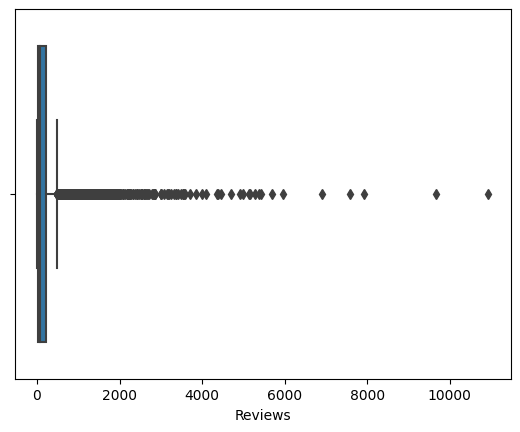

In [ ]:
sns.boxplot(data=newDf, x="Reviews")

In [ ]:
filtered_records = newDf[newDf['Restaurant Name'] == 'Le Petit Souffle']
filtered_records

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
0,6317637,Le Petit Souffle,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...",121.027535,14.565443,"French, Japanese, Desserts",4.8,314


##**Popular Cuisine amongst Restaurant**

In [ ]:
# Split the 'Cuisines' column into a list of cuisines and explode the DataFrame
newDf_exploded = newDf.assign(Cuisines=newDf['Cuisines'].str.split(', ')).explode('Cuisines')

# Count the number of restaurants for each cuisine
count_per_cuisine = newDf_exploded['Cuisines'].value_counts().reset_index()

# Rename the columns for clarity
count_per_cuisine.columns = ['Cuisine', 'Number of Restaurants']

# Display the result
count_per_cuisine

,Cuisine,Number of Restaurants
0,North Indian,2588
1,Chinese,1915
2,Fast Food,1352
3,Italian,713
4,Mughlai,698
...,...,...
136,Durban,1
137,Irish,1
138,Fish and Chips,1
139,Armenian,1


###**Top 20 Restaurant based on Rating and Reviews**

In [ ]:
# Top 20 restaurants based on Rating and Reviews
top_restaurants = newDf.sort_values(by=['Rating', 'Reviews'], ascending=False)[:20]
top_restaurants

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
2414,20842,Barbeque Nation,Kolkata,"K1, RDB Boulevard, Block EP & GP, Sector 5, Sa...",88.433452,22.569358,"North Indian, Chinese",4.9,5966
2307,94286,AB's - Absolute Barbecues,Hyderabad,"Plot 483, 4th Floor, Pemmasani Complex, Bajaj ...",78.397865,17.438263,"European, Mediterranean, North Indian",4.9,5434
2495,17806994,Mirchi And Mime,Mumbai,"Transocean House, Lake Boulevard, Hiranandani ...",72.907385,19.120083,"North Indian, South Indian, Mughlai",4.9,3244
3013,310143,Naturals Ice Cream,New Delhi,"L-8, Outer Circle, Connaught Place, New Delhi",77.222148,28.634348,Ice Cream,4.9,2620
374,17580142,McGuire's Irish Pub & Brewery,Pensacola,"600 E Gregory Street, Pensacola, FL 32502",-87.202700,30.417900,"Burger, Bar Food, Steak",4.9,2238
9296,7417450,Talaga Sampireun,Tangerang,"Jl. Boulevard Bintaro Jaya Blok B7/N1, Bintaro...",106.726119,-6.269914,"Sunda, Indonesian",4.9,2212
3601,2004,Indian Accent - The Manor,New Delhi,"The Manor, 77, Friends Colony, New Delhi",77.257106,28.570142,Modern Indian,4.9,1934
2409,25570,Barbeque Nation,Kolkata,"24, 1st Floor, Park Center Building, Park Stre...",88.354127,22.551084,"North Indian, Chinese",4.9,1753
9279,7422633,Talaga Sampireun,Jakarta,Jl. Lingkar Luar Barat,106.728508,-6.168467,"Sunda, Indonesian",4.9,1662
9291,7417455,Talaga Sampireun,Jakarta,"Taman Impian Jaya Ancol, Jl. Lapangan Golf 7, ...",106.833553,-6.126860,"Sunda, Indonesian",4.9,1640


##**Most restaurants in a city**

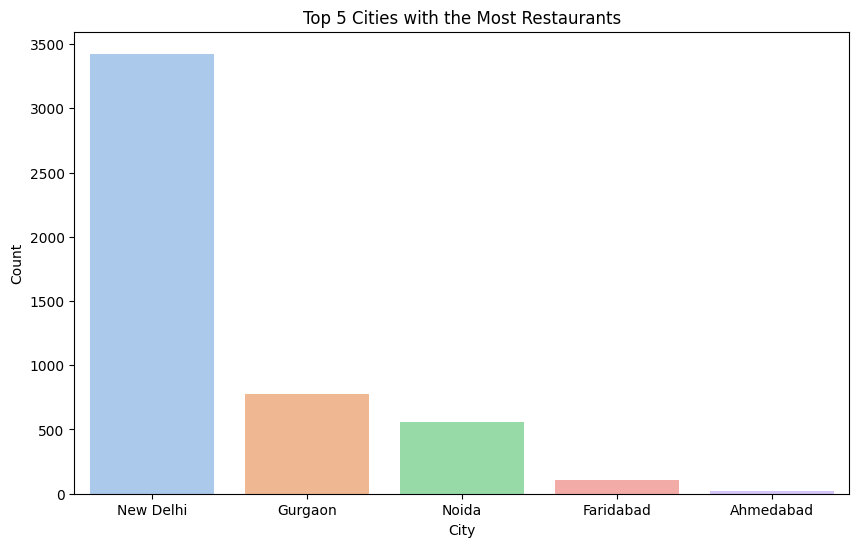

In [ ]:
# Most restaurants in a city

group = newDf.groupby('City').size()
top_5_cities = group.sort_values(ascending=False).head(5)

# Create a bar plot
plt.figure(figsize=(10, 6))

sns.barplot(x=top_5_cities.index, y=top_5_cities.values, palette="pastel", order=top_5_cities.index)

# Set plot labels and title
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 5 Cities with the Most Restaurants')

# Show the plot
plt.show()

##**Average Restaurant Rating according to City**

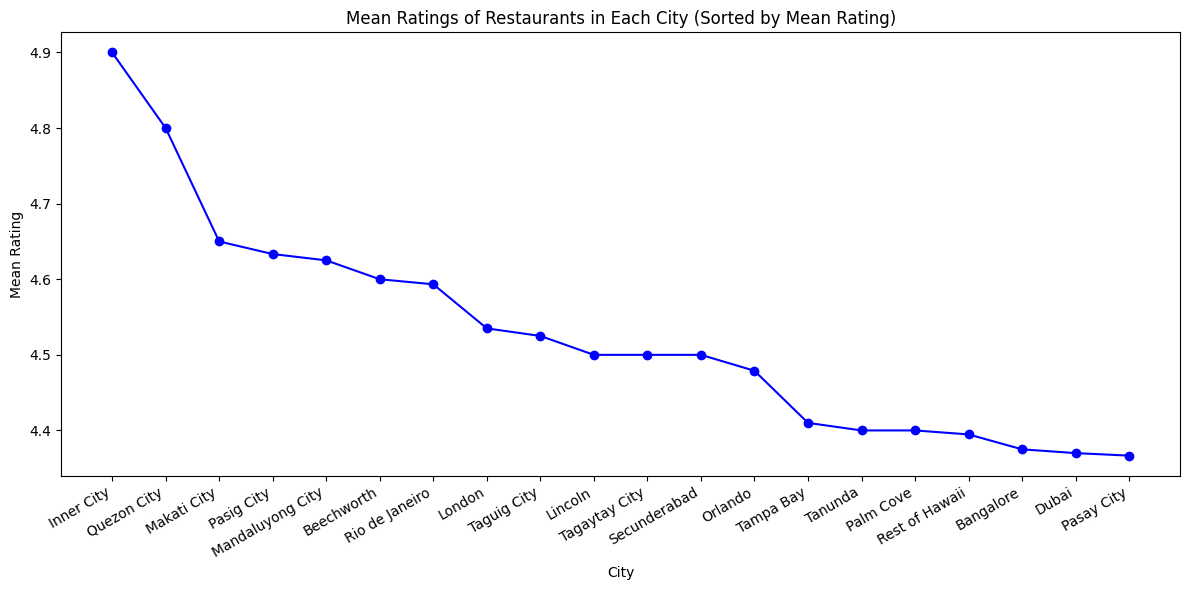

In [ ]:
# Group by City and calculate the mean rating
cities_group = newDf.groupby('City')
mean_ratings = cities_group['Rating'].mean()

# Sort cities by mean rating in descending order
mean_ratings_sorted = mean_ratings.sort_values(ascending=False).head(20)

# Create a line plot for sorted mean ratings
plt.figure(figsize=(12, 6))

plt.plot(mean_ratings_sorted.index, mean_ratings_sorted.values, marker='o', linestyle='-', color='b')

# Set plot labels and title
plt.xlabel('City')
plt.ylabel('Mean Rating')
plt.title('Mean Ratings of Restaurants in Each City (Sorted by Mean Rating)')

plt.xticks(rotation=30, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

##**Rating Distribution Graph**

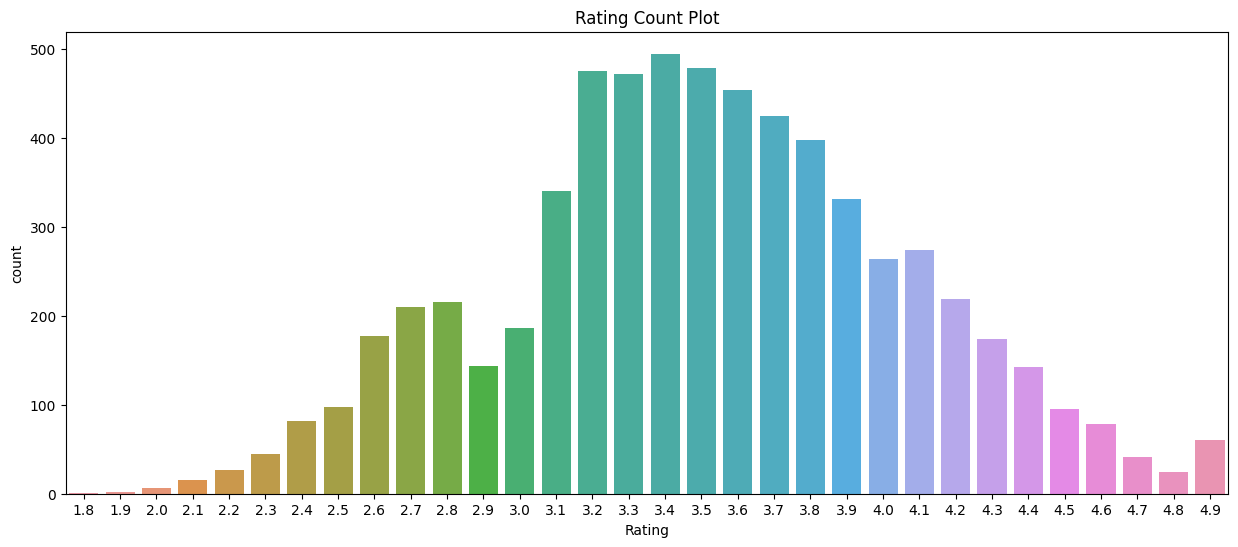

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data=newDf, x='Rating')

plt.title('Rating Count Plot')

plt.show()

##**Popular cuisines in a city**

In [ ]:
# Select the target City
desired_city = 'New Delhi'

# Filter the DataFrame for the desired city
city_df = newDf[newDf['City'] == desired_city]

# Split the 'Cuisines' column into a list of cuisines and explode the DataFrame
city_df_exploded = city_df.assign(Cuisines=city_df['Cuisines'].str.split(', ')).explode('Cuisines')

# Count the number of restaurants for each cuisine in the city
count_per_cuisine_city = city_df_exploded['Cuisines'].value_counts().reset_index()

# Rename the columns for clarity
count_per_cuisine_city.columns = ['Cuisine', 'Number of Restaurants']

# Display the result
count_per_cuisine_city.head()

,Cuisine,Number of Restaurants
0,North Indian,1543
1,Chinese,1128
2,Fast Food,872
3,Mughlai,429
4,Italian,352


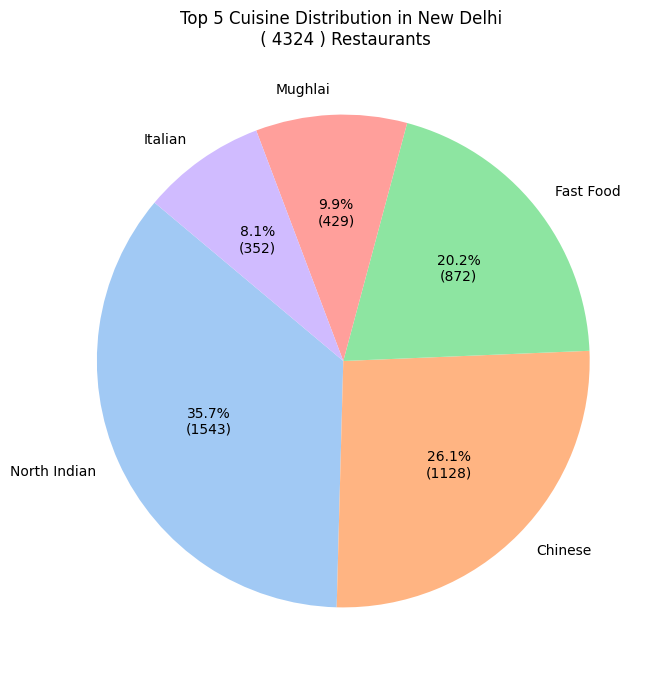

In [ ]:
# Get the top 5 cuisines
top_5_cuisines = count_per_cuisine_city.head(5)

# Plot a pie chart of the result
total_restaurants = top_5_cuisines['Number of Restaurants'].sum()

plt.figure(figsize=(12, 8))
plt.pie(top_5_cuisines['Number of Restaurants'], labels=top_5_cuisines['Cuisine'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * top_5_cuisines['Number of Restaurants'].sum()), startangle=140, colors=sns.color_palette("pastel"))
plt.title(f'Top 5 Cuisine Distribution in {desired_city} \n ( {total_restaurants} ) Restaurants')
plt.show()

##**Top rated restaurants in a city**

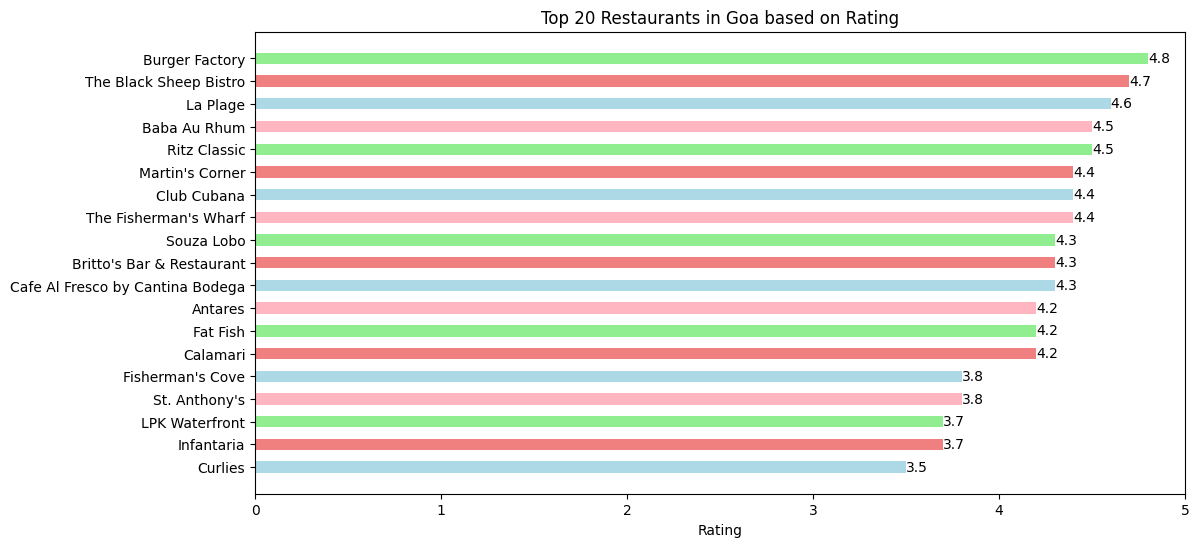

In [ ]:
# Select the target City
desired_city = 'Goa'

# Records
records = 20

# Filter the DataFrame for the desired city
city_df = newDf[newDf['City'] == desired_city].drop_duplicates(subset='Restaurant Name')

# Sort the resulting DataFrame in descending order based on the 'Rating' column and select the top 5
top_city_df = city_df.sort_values(by='Rating', ascending=False).head(records)
top_city_df

ratings = top_city_df['Rating']
restaurants = top_city_df['Restaurant Name']
bar_colors = ['lightgreen', 'lightcoral', 'lightblue', 'lightpink']

# Plotting the bar chart
plt.figure(figsize=(12, 6))

bars = plt.barh(restaurants, ratings, color=bar_colors, height=0.5)
plt.barh(restaurants, ratings, color=bar_colors, height=0.5)
plt.xlabel('Rating')
plt.title(f'Top {records} Restaurants in {desired_city} based on Rating')
plt.xlim(0, 5)
plt.gca().invert_yaxis()

# Add ratings as annotations on each bar
for bar, rating in zip(bars, ratings):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{rating:.1f}', ha='left', va='center')

plt.show()

# **Model Creation**

##**User reviews**

In [ ]:
user_reviews_data = [
    { 'rating': 2.0, 'restaurantId': 309578 },
    { 'rating': 4.5, 'restaurantId': 7661 },
    { 'rating': 3.0, 'restaurantId': 18350112 },
    { 'rating': 4.0, 'restaurantId': 404 },
    # { 'rating': 3.5, 'restaurantId': 310463 },
    # { 'rating': 5.0, 'restaurantId': 18254558 },
    # { 'rating': 1.0, 'restaurantId': 7246 },
    # { 'rating': 5.0, 'restaurantId': 1683 },
]
user_coordinates = [28.6139, 77.2090]

##**User Location**

In [ ]:
# Initialize a geolocator
geolocator = Nominatim(user_agent="RRS")

# Geocoding - Get address components from coordinates
location = geolocator.reverse((user_coordinates[0], user_coordinates[1]), language="en")
address_components = location.raw.get("address", {})

# Extract the city
user_city = address_components.get("city", "City not found")
print("User City:", user_city)

User City: New Delhi


In [ ]:
# Center the map around the user location
map_center = [user_coordinates[0], user_coordinates[1]]
user_location = folium.Map(location=map_center, zoom_start=15)
folium.Marker(location=user_coordinates, popup="User Location").add_to(user_location)

# Display the map
user_location

##**User Reviewed Restaurants**

In [ ]:
restaurant_ids = [review['restaurantId'] for review in user_reviews_data]
reviewed_data = newDf[newDf['Restaurant ID'].isin(restaurant_ids)].reset_index(drop=True)
reviewed_data

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
0,7661,New Baba Da Dhaba,New Delhi,"J1/110, Gupta Colony, Near Saini Estate, Khirk...",77.217028,28.533122,"North Indian, Mughlai, Chinese",2.0,84
1,404,Yo! China,New Delhi,"G-9, V3S Mall, Laxmi Nagar, New Delhi",77.286034,28.636704,Chinese,2.0,191
2,309578,Moksha,New Delhi,"Plot 3 & 4, Central Market, West Punjabi Bagh,...",77.132789,28.670921,"Chinese, North Indian, Italian",3.2,54
3,18350112,Target Ice Cream & Bakers,New Delhi,"Ground Floor, 4, Vigyan Vihar, Anand Vihar, Ne...",77.312854,28.660001,"Desserts, Bakery, Pizza, Burger, Continental",3.6,58


##**User Preffered Cuisines Visualization**

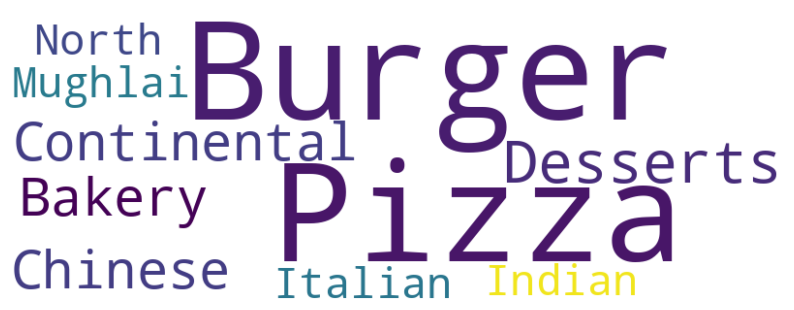

In [ ]:
# unique set of cuisines
preferred_cuisines = set()

# Iterate through rows in the DataFrame
for row in reviewed_data.itertuples():
    cuisines = row.Cuisines.split(', ')
    preferred_cuisines.update(cuisines)

# Create a text string with cuisines for the word cloud
cuisines_text = ', '.join(preferred_cuisines)

# Generate a word cloud with a custom color map and black background
wordcloud = WordCloud(width=800, height=300, background_color='white').generate(cuisines_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

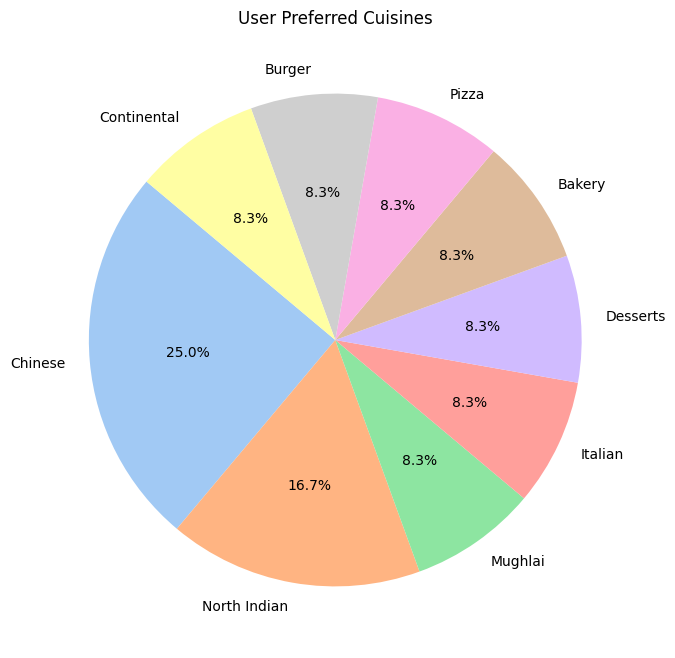

In [ ]:
# Split the 'Cuisines' column into a list of cuisines and explode the DataFrame
reviewed_data_exploded = reviewed_data.assign(Cuisines=reviewed_data['Cuisines'].str.split(', ')).explode('Cuisines')

# Count the number of restaurants for each cuisine in the city
reviewed_data_cuisines = reviewed_data_exploded['Cuisines'].value_counts()

# Create a pie chart
plt.figure(figsize=(12, 8))
plt.pie(reviewed_data_cuisines, labels=reviewed_data_cuisines.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('User Preferred Cuisines')
plt.show()

##**Vector Space Model**

##**Filtering DataSet according to User Data**

In [ ]:
# Create a copy of the DataFrame
filteredDf = newDf[newDf['City'] == user_city]

# Reset the index of the filtered DataFrame
filteredDf = filteredDf.drop_duplicates(subset='Restaurant Name').reset_index(drop=True)

# Print the filtered DataFrame
filteredDf

,Restaurant ID,Restaurant Name,City,Address,Longitude,Latitude,Cuisines,Rating,Reviews
0,7018,Muffins,New Delhi,"B-3/66, Janakpuri, New Delhi",77.091798,28.627836,"Bakery, Fast Food",1.9,66
1,149,Subway,New Delhi,"54, The India Mall, Community Centre, New Frie...",77.268517,28.561470,"American, Fast Food, Salad, Healthy Food",1.9,146
2,7661,New Baba Da Dhaba,New Delhi,"J1/110, Gupta Colony, Near Saini Estate, Khirk...",77.217028,28.533122,"North Indian, Mughlai, Chinese",2.0,84
3,404,Yo! China,New Delhi,"G-9, V3S Mall, Laxmi Nagar, New Delhi",77.286034,28.636704,Chinese,2.0,191
4,3918,Wah Ji Wah,New Delhi,"B-6/1, Double Story, Near Metro Pillar 371, Ra...",77.128443,28.651778,North Indian,2.1,54
...,...,...,...,...,...,...,...,...,...
2592,18237321,Echoes Satyaniketan,New Delhi,"17, 1st Floor, Opposite Sri Venkateshwara Coll...",77.167164,28.587609,"Cafe, Continental, Italian, Mexican, Chinese, ...",4.7,1563
2593,18429148,Pa Pa Ya,New Delhi,"Dome, Level 4, Select Citywalk, A-3, District ...",77.218698,28.528456,"Asian, Chinese, Thai, Japanese",4.7,268
2594,18445790,Kopper Kadai,New Delhi,"J2/6B, 1st & 2nd Floor, B.K. Dutta Market, Raj...",77.119547,28.647627,North Indian,4.8,83
2595,2004,Indian Accent - The Manor,New Delhi,"The Manor, 77, Friends Colony, New Delhi",77.257106,28.570142,Modern Indian,4.9,1934


##**Vectorization and Similarity Matrix**

In [ ]:
# Create a TF-IDF vectorizer to convert cuisines into numerical data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filteredDf["Cuisines"].tolist())

# Compute the cosine similarity between cuisines
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(2597, 2597)

##**Similarity Matrix Heatmap**

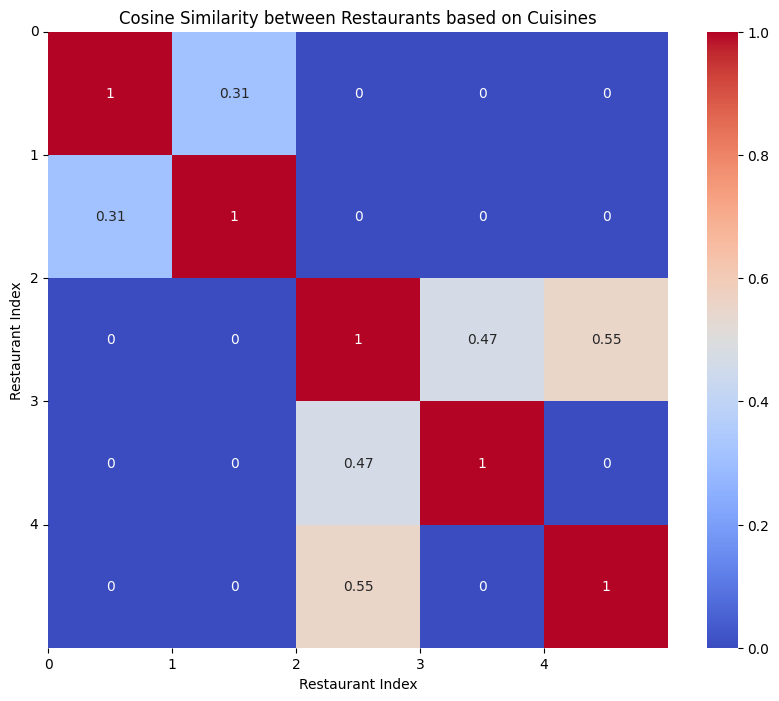

In [ ]:
# Plotting the cosine similarity matrix

# Sample size to show relations
sample_size = 5
sampled_cosine_sim = cosine_sim[:sample_size, :sample_size]

plt.figure(figsize=(10, 8))

# Generate heatmap
sns.heatmap(sampled_cosine_sim, annot=True, cmap='coolwarm', xticklabels=filteredDf.index[:sample_size], yticklabels=filteredDf.index[:sample_size])

# Rotate the y-axis labels for better readability
plt.yticks(rotation=0)

# Set x-axis and y-axis labels using sampled indices
plt.xticks(np.arange(sample_size), filteredDf.index[:sample_size])
plt.yticks(np.arange(sample_size), filteredDf.index[:sample_size])

# labels and title
plt.xlabel('Restaurant Index')
plt.ylabel('Restaurant Index')
plt.title('Cosine Similarity between Restaurants based on Cuisines')

# Show the plot
plt.show()

##**Recommendation**

In [ ]:
indices = pd.Series(filteredDf.index, index=filteredDf['Restaurant Name']).drop_duplicates()

In [ ]:
# Function to get restaurant recommendations
def get_recommendations(similarity_threshold, restaurant_rating_threshold):

    # Create an empty DataFrame to store recommended restaurants
    recommendations = pd.DataFrame(columns=['Restaurant ID', 'Restaurant Name', 'City', 'Cuisines', 'Rating', 'Reviews'])

    # Loop through reviews in the DataFrame
    for index, review in reviewed_data.iterrows():

        # Get restaurant indices based on name
        name = review['Restaurant Name']
        index_in_filteredDf = indices[name]

        # Get the cosine similarity scores for the cuisine
        sim_scores = list(enumerate(cosine_sim[index_in_filteredDf]))

        # Sort the restaurants based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the restaurant indices with high similarity
        top_restaurant_indices = [x[0] for x in sim_scores if x[1] >= similarity_threshold]

        # Get the restaurant indices with high similarity and rating greater than 3
        top_restaurant_indices = [i for i in top_restaurant_indices if (
            filteredDf.at[i, 'Rating'] > restaurant_rating_threshold and
            filteredDf.at[i, 'Restaurant ID'] != review['Restaurant ID']
        )]

        # Add the recommendations to the DataFrame
        recommendations = pd.concat([recommendations, filteredDf.iloc[top_restaurant_indices]])

    # Drop duplicate rows based on 'Restaurant Name' and reset index
    recommendations = recommendations.drop_duplicates(subset='Restaurant Name').reset_index(drop=True)

    return recommendations

# Get restaurant recommendations based on user reviews
recommendations = get_recommendations(0.75, 3)

# Display the recommendations
recommendations

,Restaurant ID,Restaurant Name,City,Cuisines,Rating,Reviews,Address,Longitude,Latitude
0,306107,Great Plates By AJ,New Delhi,"North Indian, Chinese, Mughlai",3.1,77,"G-1-4, DLF Galleria Mall, District Centre, May...",77.296413,28.592181
1,18342098,Chef's Paradise,New Delhi,"North Indian, Mughlai, Chinese",3.1,36,"B 75, New Ashok Nagar, Vasundhara Enclave, New...",77.306500,28.591545
2,572,Madhuban,New Delhi,"North Indian, Mughlai, Chinese",3.1,151,"18-19, PVR Anupam Complex, Community Center",77.207001,28.522917
3,18273623,Al-Bawarchi,New Delhi,"North Indian, Mughlai, Chinese",3.1,15,"33, Ground Floor, Living Style Mall, Jasola, N...",77.297044,28.541366
4,1147,Gola Northend,New Delhi,"Mughlai, North Indian, Chinese",3.1,155,"Plot 5, Local Shopping Centre, Gujranwala Town...",77.189538,28.701458
...,...,...,...,...,...,...,...,...,...
304,4825,QD's Restaurant,New Delhi,"Chinese, North Indian, Fast Food, Italian",3.9,2724,"2520, 1st Floor, Hudson Lane, Kingsway Camp, D...",77.204256,28.695159
305,4227,Chill'm Bar & Cafe,New Delhi,"North Indian, Italian, Chinese, Fast Food",4.2,300,"38, Bunglow Road, Kamla Nagar, New Delhi",77.204722,28.683924
306,2724,1911 - The Imperial,New Delhi,"North Indian, Chinese, South Indian, Italian",3.9,272,"The Imperial, Janpath, New Delhi",77.218185,28.625443
307,18361742,Cafe Shloka,New Delhi,"Cafe, Italian, Chinese, North Indian",3.5,63,"183, Jagriti Enclave, Karkardooma, New Delhi",77.309037,28.653704


##**Calculating Precision**

In [ ]:
def calculate_precision(actual, predicted):
    true_positives = 0
    false_positives = 0

    for recommended_cuisine in predicted:
        found_match = any(preferred_cuisine.lower() in recommended_cuisine.lower() for preferred_cuisine in actual)
        if found_match:
            true_positives += 1
        else:
            false_positives += 1

    precision = (true_positives / (true_positives + false_positives)) * 100 if (true_positives + false_positives) != 0 else 0

    return precision


precision = calculate_precision(preferred_cuisines, recommendations['Cuisines'])

# Display the evaluation metric
print(f"Precision: {precision:.2f}%")

Precision: 100.00%


##**Top 10 Recommendations**

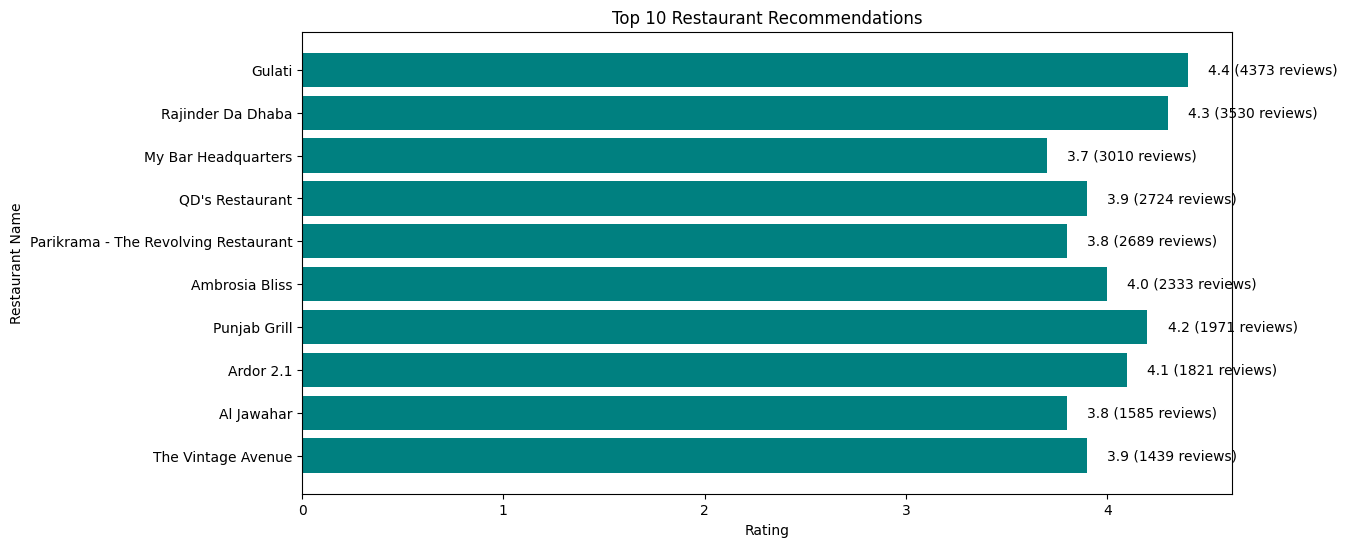

In [ ]:
# Sort recommendations by reviews and ratings
top_recommendations = recommendations.sort_values(by=['Reviews', 'Rating'], ascending=False).head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top_recommendations['Restaurant Name'], top_recommendations['Rating'], color='teal')

# Add data labels
for bar, rating, reviews in zip(bars, top_recommendations['Rating'], top_recommendations['Reviews']):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2, f'{rating:.1f} ({reviews} reviews)', va='center')

# Customize plot appearance
plt.title('Top 10 Restaurant Recommendations')
plt.xlabel('Rating')
plt.ylabel('Restaurant Name')
plt.gca().invert_yaxis()
plt.show()

##**Showing Recommendations on Map**

In [ ]:
latitude = recommendations['Latitude'].tolist()
longitude = recommendations['Longitude'].tolist()
restaurants = recommendations['Restaurant Name'].tolist()
ratings = recommendations['Rating'].tolist()

# Center the map around the first restaurant
map_center = [latitude[0], longitude[0]]

restaurant_map = folium.Map(location=map_center, zoom_start=11)

# Add markers for each restaurant
for lat, lon, restaurant, rating in zip(latitude, longitude, restaurants, ratings):
  folium.Marker([lat, lon], popup=f'Restaurant Name: {restaurant}\nRating: {rating:.1f}').add_to(restaurant_map)

# Display the map
restaurant_map